**Libraries**

In [19]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns 
%config InlineBackend.figure_format ='retina'
import random
from functools import reduce
from sklearn.ensemble import RandomForestRegressor
from datetime import date
import time

**Spotify API Call**

In [20]:
#used for inserting your username and credentials that you can obtain from spotify developer
client_id= 'ebbb035aedf7428cbdbbd6dd31df89a8'
client_secret= '394032044ced4d8e9df0f9d435f88794'

redirect_uri='http://localhost:8910/callback'
username='224qqnsvbhlau4fhtpl4wpogi'

scope ='user-top-read'


In [21]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, 
                                                      client_secret=client_secret)
                                                      
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

token = util.prompt_for_user_token(username,scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

**Extract Top Tracks**

In [22]:
results = sp.current_user_top_tracks(limit=50, offset=0,time_range='long_term')

# Convert the results into a dataframe

track_name=[]
track_id=[]
artist=[]
new=[]
album=[]
duration=[]
popularity=[]

for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_top_tracks = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "duration": duration, 
                             "popularity": popularity})

df_top_tracks

,track_name,album,track_id,artist,duration,popularity
0,MIDDLE CHILD,MIDDLE CHILD,2JvzF1RMd7lE3KmFlsyZD8,J. Cole,213593,84
1,Climax (feat. 6lack),On the Run,4N9QsmvQJcGwJHAmDmBttU,Young Thug,189093,65
2,سماع منّي وضل سكار,سماع منّي وضل سكار,4C6gnywwpZWQa8ixhwrSKU,Bassel Sakr,141191,12
3,Stan,East Atlanta Love Letter,1mggAh6xgnKUT6ukw3AU9A,6LACK,303750,59
4,You Are The Reason - Duet Version,Only Human (Special Edition),1x3W8RZxW94lrVGhP95qA6,Calum Scott,190760,73
5,Sin (feat. Jaden Smith),On the Run,1Jl21sidRpEdlVBvYbssLx,Young Thug,202533,65
6,Into You,10X over Riddim (Soca 2019 Trinidad and Tobago...,7pwmtknVJmDfTBSvtzhBEU,Precision Productions,198167,0
7,Whole Wide World,Whole Wide World,6lKKCEeRunxMGM8xgejlyd,Berhana,243160,42
8,Broke,Broke,1JqcZQCnxjDOfZZwQidb1H,Samm Henshaw,207722,65
9,The Box,Please Excuse Me For Being Antisocial,0nbXyq5TXYPCO7pr3N8S4I,Roddy Ricch,196652,92


**Feature Extraction**

In [23]:
def get_features(sp,df):
    playlist = df[['track_id','track_name']]
    features = []
    
    features += sp.audio_features(playlist.iloc[0:50, 0])

    feature_list = []
    for feature in features:
        feature_list.append([feature['danceability'],
                        feature['energy'],
                        feature['key'],
                        feature['loudness'],
                        feature['mode'],
                        feature['speechiness'],
                        feature['acousticness'],
                        feature['instrumentalness'],
                        feature['liveness'],
                        feature['valence'],
                        feature['tempo'],
                        feature['duration_ms']]
                       )

    df_audio_feature = pd.DataFrame(feature_list, columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                                                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                                          'duration_ms'])
    df_playlist_audio_features = pd.concat([playlist, df_audio_feature], axis=1)
    return df_playlist_audio_features

In [24]:
df_final_features = get_features(sp,df_top_tracks)
#Drop the mode feature as it is binary
del df_final_features['mode']
df_final_features

,track_id,track_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2JvzF1RMd7lE3KmFlsyZD8,MIDDLE CHILD,0.837,0.364,8,-11.713,0.2760,0.149000,0.000000,0.2710,0.4630,123.984,213594
1,4N9QsmvQJcGwJHAmDmBttU,Climax (feat. 6lack),0.829,0.362,0,-11.546,0.2310,0.060800,0.000000,0.1350,0.3690,122.912,189093
2,4C6gnywwpZWQa8ixhwrSKU,سماع منّي وضل سكار,0.743,0.759,1,-4.841,0.1640,0.131000,0.000000,0.3900,0.8000,99.979,141192
3,1mggAh6xgnKUT6ukw3AU9A,Stan,0.333,0.328,3,-9.144,0.0401,0.821000,0.000173,0.1270,0.1520,92.889,303750
4,1x3W8RZxW94lrVGhP95qA6,You Are The Reason - Duet Version,0.403,0.356,10,-7.547,0.0298,0.382000,0.000000,0.1480,0.1510,171.454,190760
5,1Jl21sidRpEdlVBvYbssLx,Sin (feat. Jaden Smith),0.889,0.385,11,-11.767,0.1650,0.005440,0.000000,0.2740,0.2350,125.995,202533
6,7pwmtknVJmDfTBSvtzhBEU,Into You,0.883,0.841,1,-2.802,0.1580,0.176000,0.000000,0.1250,0.6550,99.978,198168
7,6lKKCEeRunxMGM8xgejlyd,Whole Wide World,0.508,0.457,4,-7.320,0.0383,0.849000,0.000000,0.0989,0.4870,100.221,243160
8,1JqcZQCnxjDOfZZwQidb1H,Broke,0.751,0.684,1,-4.325,0.3030,0.433000,0.000006,0.1800,0.8640,89.984,207722
9,0nbXyq5TXYPCO7pr3N8S4I,The Box,0.896,0.586,10,-6.687,0.0559,0.104000,0.000000,0.7900,0.6420,116.971,196653


We can take a look at the frequency of the values present in each feature.

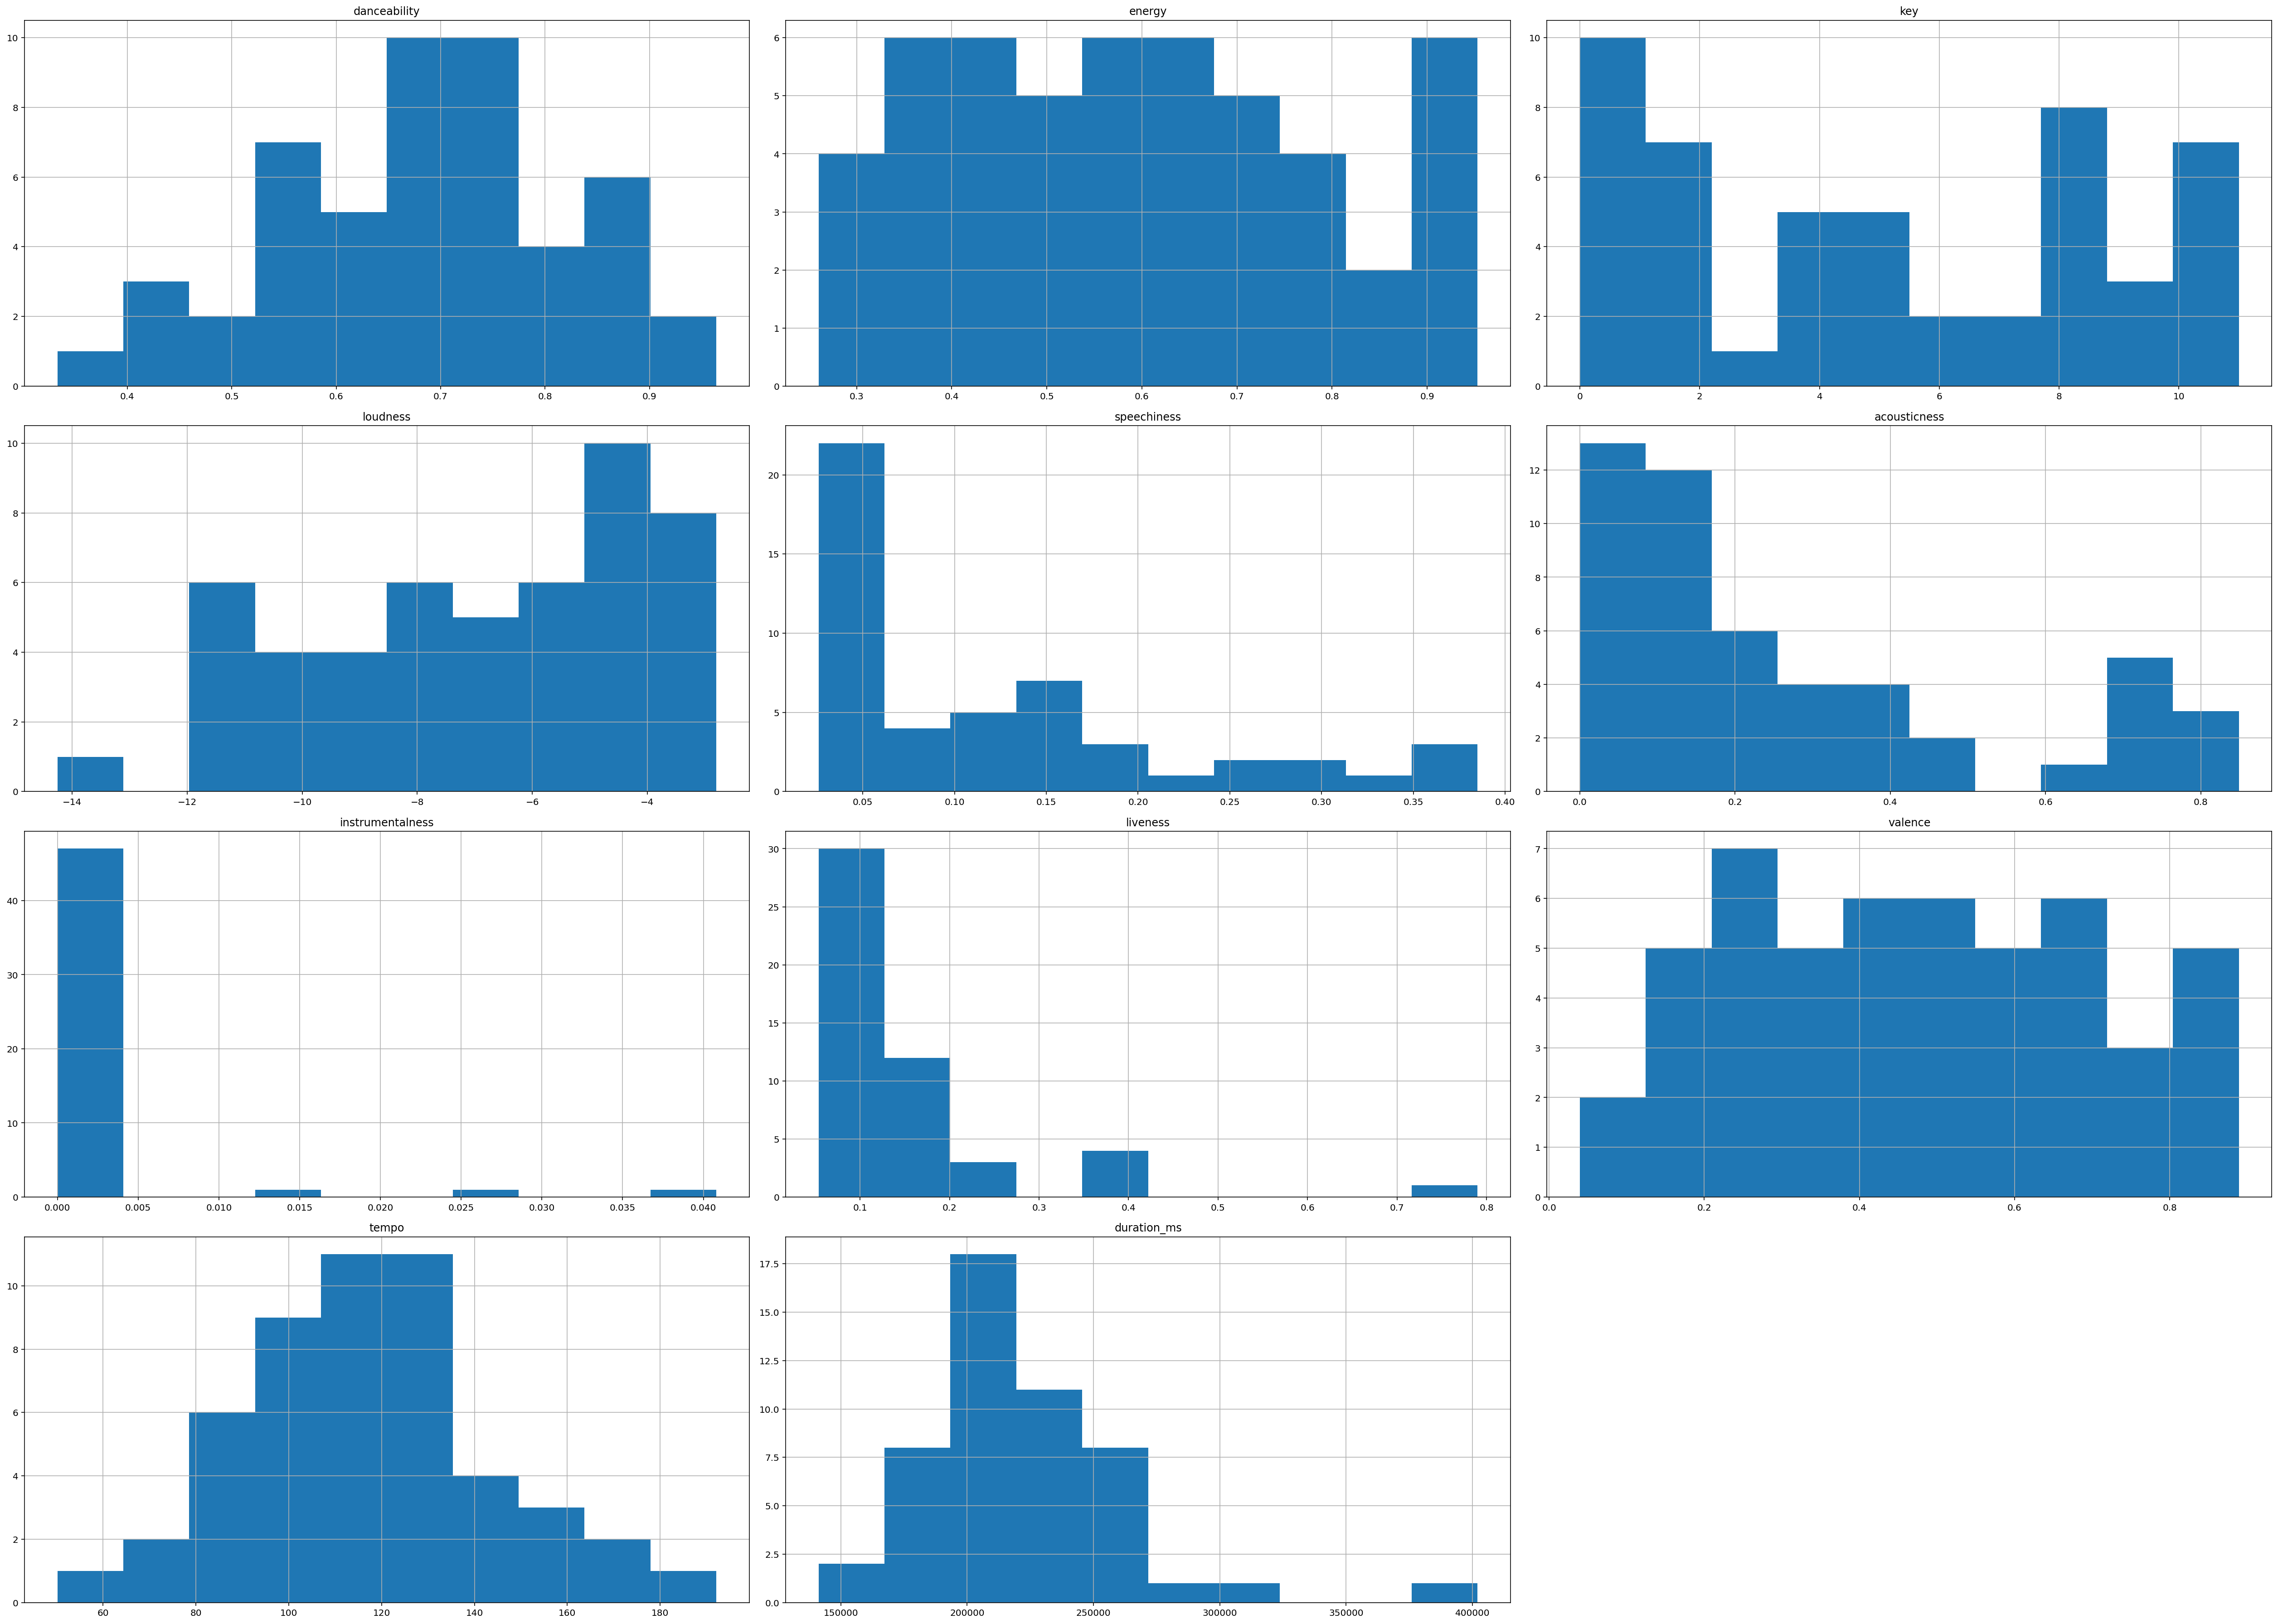

In [25]:
df_final_features.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()

I will now take all my built up playlist to then create one complilation of the best songs using the features provided. 

** User PLaylist Extraction **

In [26]:
def user_playlist(sp,username):
    playlist_id = []
    playlist_name = []
    num_tracks = []
    
    featured = sp.user_playlists(username)
    for i, items in enumerate(featured['items']):
        playlist_id.append(items['id'])
        playlist_name.append(items['name'])
        num_tracks.append(items['tracks']['total'])
    
    df_your_lib = pd.DataFrame({'playlist_id':playlist_id, 'playlist_name':playlist_name, '#tracks': num_tracks})
    return df_your_lib

In [27]:
df_user_playlists = user_playlist(sp,username)
searchfor = ['Custom', 'Discover']
df_user_playlists =  df_user_playlists[~df_user_playlists['playlist_name'].str.contains('|'.join(searchfor))]
df_user_playlists

,playlist_id,playlist_name,#tracks
0,1S455AG3UORA5W0HPZZmlI,Yara,53
1,2b3WqN1B0sLJLk7QjktR8W,My Shazam Tracks,2


I dont have many custom playlists, so i will manually add playlists that I enjoy as well as remove any playlist that doesnt have more than 10 songs to ensure we have sufficient data. 

In [28]:
#df_user_playlists= df_user_playlists.drop(df_user_playlists.index[1])

listOfSeries = [pd.Series(['1QnKkNOpY8jPDIUT4oulDH', 'Nida recomendations', 60], index=df_user_playlists.columns ) ,
                pd.Series(['2XH7v4B8Tf9D4UYJPxtJlX', 'throwback', 279], index=df_user_playlists.columns ) ,
                pd.Series(['4JbURQJ0cA9Go65G0JmBq8', 'train', 20], index=df_user_playlists.columns ) ]


df_user_playlists= df_user_playlists.append(listOfSeries , ignore_index=True)

df_user_playlists.drop( df_user_playlists[ df_user_playlists['#tracks']<10 ].index , inplace=True)
df_user_playlists

,playlist_id,playlist_name,#tracks
0,1S455AG3UORA5W0HPZZmlI,Yara,53
2,1QnKkNOpY8jPDIUT4oulDH,Nida recomendations,60
3,2XH7v4B8Tf9D4UYJPxtJlX,throwback,279
4,4JbURQJ0cA9Go65G0JmBq8,train,20


Now that my list of playlists has been made, we can extract the tracks from each playlist to analyze them to single out the best ones. It would be interesting to test this out on an account with many more playlists than I do. But we will go on with what we have.

**Fetching tracks for each playlist**

In [29]:
def get_playlist_tracks(sp, playlist_id):
    tracks = []
    offset = 0
    while True:
        track_list = sp.playlist_tracks(playlist_id, fields = None, limit = 100, offset = offset, market = None)
        tracks += track_list['items']
        
        if track_list['next'] is not None:
            offset +=100
        else:
            break
            
    track_id = []
    track_name = []
    
    try:
        for track in tracks:
            track_id.append(track['track']['id'])
            track_name.append(track['track']['name'])
    except:
            pass
    
    df_playlist_tracks = pd.DataFrame({'track_id':track_id, 'track_name': track_name})
    return df_playlist_tracks

In [30]:
#test the function
get_playlist_tracks(sp, '1S455AG3UORA5W0HPZZmlI')

,track_id,track_name
0,1bxP4M9ICllcg7mel8kH89,Reine
1,1hnk0ZhStnRSLRq4u2fM7H,Takke
2,2itnaJvNPHTUeNrY97fNws,Hola Señorita
3,5iqrbO0fhuLMiy9tYGanv6,C'est La Vie
4,2On7uB8PN8JJmBNsms8unQ,Compliqué
5,0CJ31BEjjl1tPIj0CKi9kH,Sapés comme jamais (feat. Niska) - Pilule bleue
6,3a9TMd2Yrza6HXqqlfMtfy,Est-ce que tu m'aimes ? - Pilule bleue
7,5Jzss6xqzVPGTxTUbNqtZY,كزابلنكا
8,1G27BeCfBFQHXbXLJkAps7,Y'a des jours comme ça
9,7bVOm16UuDoDGg3LqnywlH,On va s'aimer


**Get audio features within a playlist**

In [31]:
def get_audio_features(sp, playlist_id):
    playlist = get_playlist_tracks(sp, playlist_id)
    audio_features = []
    
    for i in range(len(playlist)):
        try:
            audio_features.append(sp.audio_features(playlist['track_id'][i]))
        except:
            pass
                         
    feature_list = []
    for feature in audio_features:
        try:
            feature_list.append([feature[0]['danceability'],
                            feature[0]['energy'],
                            feature[0]['key'],
                            feature[0]['loudness'],
                            feature[0]['speechiness'],
                            feature[0]['acousticness'],
                            feature[0]['instrumentalness'],
                            feature[0]['liveness'],
                            feature[0]['valence'],
                            feature[0]['tempo'],
                            feature[0]['duration_ms']]
                               )
        except:
            pass

    df_audio_feature = pd.DataFrame(feature_list, columns = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 
                                                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                                          'duration_ms'])
    df_playlist_audio_features = pd.concat([playlist, df_audio_feature], axis=1)
    df_playlist_audio_features = df_playlist_audio_features.dropna()
    return df_playlist_audio_features

In [32]:
def get_audio_features_mean (sp, playlist_id):
    playlist = get_audio_features(sp, playlist_id)
    df_mean_playlist = pd.DataFrame(playlist.mean(),columns = [playlist_id])
    return df_mean_playlist

In [ ]:
dataframes_user = []
for i in df_user_playlists['playlist_id']:
    dataframes_user.append(get_audio_features_mean(sp, i))
    
dataframes_user